# Live-stock detection (DeepForest)

## Context
### Purpose
Implement and fine-tune a prebuilt Deep Learning model to detect livestock in airborne imagery. The model is implemented using PyTorch Lightning, which simplifies the training process and allows for easy checkpointing, enabling collaborative work by saving and sharing model progress.

### Modelling Approach
The [live-stock detection model](https://huggingface.co/weecology/deepforest-livestock) from the latest version (v1.4.0) of the [DeepForest](https://deepforest.readthedocs.io/en/latest/) {cite:p}`Weinstein2020_MEE` Deep Learning model is used to predict bounding boxes corresponding to cattle from airborn RGB images.

As a PyTorch Lightning module, this model can be fine-tuned easily, and checkpoints can be saved as [.safetensors](https://huggingface.co/docs/safetensors/index), making it possible to upload the trained models to platforms like Hugging Face for open collaboration.

The prebuilt model was trained on a [limited dataset](https://new.wildlabs.net/discussion/global-model-livestock-detection-airborne-imagery-data-applications-and-needs) {cite:p}`livestockdataset`. According to the package's documentation, "the prebuilt models will always be improved by adding data from the target area". As such, this notebook will explore the improvement in the model's performance in live-stock detection from fine-tuning on local data.

### Description
This notebook will explore the capabilities of the DeepForest package. In particular, it will demonstrate how to:

- Detect livestock in airborne imagery using the prebuilt livestock detection model.
- Fine-tune the model using a novel publicly-available dataset.
- Evaluate the model's performance before and after fine-tuning.
- Save and share model checkpoints throughout the process, allowing for reproducibility and collaboration on Hugging Face.

<div style="background-color: #ffe4b5; padding: 10px; border-left: 5px solid #ffa500;">
<b>Note:</b> 
Due to the memory constraints of the Binder environment, some steps of the machine learning pipeline are omitted from the notebook. In such cases, we include the relevant code so that it can still be executed in an environment with greater memory and processing power.
</div>

### Highlights
The prebuilt model was trained on 2347 training and 690 validation annotations, and its performance metrics on the test set (subset of 356 images excluded from training/validation sets) showed substantial gains:
- __Box Recall:__ Improved from 0.3862 to 0.9391
- __Box Precision:__ Improved from 0.4925 to 0.8628
- __Mean IoU:__ Improved from 0.2070 to 0.6095

These results demonstrate the potential of improving the model further by sharing checkpoints as open-source models on Hugging Face, enabling collaborative enhancements based on additional local data.

## Import libraries

In [1]:
import os
import glob
import urllib

import numpy as np
import pandas as pd

import xmltodict
import cv2
import matplotlib.pyplot as plt
from PIL import Image

from deepforest import main
from deepforest.visualize import plot_predictions
from huggingface_hub import hf_hub_download

import torch

from shapely.geometry import box
from skimage.exposure import equalize_hist

import pooch

import warnings
warnings.filterwarnings(action='ignore')

%matplotlib inline

/srv/conda/envs/notebook/lib/python3.12/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## Set project structure

In [2]:
notebook_folder = './notebook'
if not os.path.exists(notebook_folder):
    os.makedirs(notebook_folder)

extract_dir = os.path.join(notebook_folder)
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir, exist_ok=True)

## Fetch images and annotations from Zenodo

Fetch sample images and ground-truth labels from [Zenodo](https://zenodo.org/records/14219057).

Data were sourced from Harvard's publicly accessible [ODjAR Dataverse](https://dataverse.harvard.edu/dataverse/ODjAR). Specifically, @livestockdataset, which includes "a large dataset containing aerial images from fields in Juchowo, Poland and Wageningen, the Netherlands, with annotated cows present in the images using Pascal VOC XML Annotation Format." There are effectively 3 datasets: Carus_2018, Carus_2019, and Juchowo_2019. There are XML files with the annotations: cow, cow ID, and cow pose.

Given that this dataset is stored as a multi-part archive, it was necessary to download and unzip the files using `pyunpack`, then distribute the subset of images used to train/validate and test the model separately. This process requires at least 7 GB of available space.


In [3]:
zenodo = pooch.create(
    # Use the default cache folder for the operating system
    path=f".",
    base_url="doi:10.5281/zenodo.14219057/",
    # The registry specifies the files that can be fetched
    registry={
        "annotations.csv": "md5:793358e2c3c59a3a621ff66b31533996",
        "test.csv": "md5:9b1fcc44aec7a678e736366b307f27f8",
        "test_baseline.csv": "md5:95325651118ebf92ec440c440175848c",
        "test_finetuned.csv": "md5:5ef15e75fe4e2d990ac197278a5677e8",
        "20181001 (196).JPG": "md5:d84d3487b4fea5a769b754fcd7655527",
        "20181002 (228).JPG": "md5:6cedf6881250de9d6eeeabb65f245588",
    },
)

<div style="background-color: #ffe4b5; padding: 10px; border-left: 5px solid #ffa500;">
<b>Note:</b> 
Due to the memory constraints of the Binder environment, this step is omitted from the notebook. To execute locally, run the following code:
</div>

```python
unzipped_files = pooch.retrieve(
    url="doi:10.5281/zenodo.14219057/images.zip",
    known_hash="md5:90a37ff7c1a166f671dac952cfae2708",
    processor=pooch.Unzip(extract_dir=extract_dir),
    path=f"."
)

# Load the CSV (annotations)
test_path = [file for file in unzipped_files if file.endswith('test.csv')][0]
test_df = pd.read_csv(test_path)
```

## Baseline model

### Download baseline model

Load the model from DeepForest's [Hugging Face](https://huggingface.co/weecology) repository. The `load_model()` function loads the tree crown detection model by default; the following pre-trained models can also be specified:
- weecology/deepforest-bird
- weecology/everglades-nest-detection
- weecology/cropmodel-deadtrees
- weecology/deepforest-livestock

<div style="background-color: #ffe4b5; padding: 10px; border-left: 5px solid #ffa500;">
<b>Note:</b> 
Due to the memory constraints of the Binder environment, this step is omitted from the notebook. To execute locally, run the following code:
</div>

```python
from deepforest import main

model = main.deepforest()
model.load_model(model_name="weecology/deepforest-livestock", revision="main")
```

The DeepForest models have identical architectures, but different weights, as tree crown detection model's layers were updated to adapt to the new task. The model weights are saved in [.safetensors](https://huggingface.co/docs/safetensors/index) format.


### Evaluate baseline performance

The baseline performance of the pretrained livestock detection model is evaluated on the test set, using the `evaluate()` method.

<div style="background-color: #ffe4b5; padding: 10px; border-left: 5px solid #ffa500;">
<b>Note:</b> 
Due to the memory constraints of the Binder environment, this step is omitted from the notebook. To execute locally, run the following code:
</div>

```python
model.label_dict = {'cow': 0}  # label defaults to 'tree'; change to 'cow', 'bird', etc.
model.config['gpus'] = '-1'  # Use GPU (set to '0' for the first GPU or '-1' for all GPUs)
model.config['workers'] = 0

# Set the directory to save the results of the pretrained model
baseline_save_dir = os.path.join(notebook_folder, 'baseline_pred_result')
os.makedirs(baseline_save_dir, exist_ok=True)

# Evaluate the pretrained model on the test set (using test_file)
baseline_results = model.evaluate(test_path, os.path.dirname(test_path), iou_threshold=0.4, savedir=baseline_save_dir)

test_baseline_csv = os.path.join(baseline_save_dir, 'test_baseline.csv')
pd.DataFrame(baseline_results['results']).to_csv(test_baseline_csv, index=False)
```

The baseline prediction results are saved in the [Zenodo](https://zenodo.org/records/14219057) folder as `test_baseline.csv`.

The model's performance is assessed by calculating key metrics such as __Box Recall__, __Box Precision__, and __Mean IoU__ (Intersection over Union), which indicate how accurately the model detects livestock in the test imagery. This serves as a benchmark to compare improvements after fine-tuning:
- __Box Recall:__ 0.3862
- __Box Precision:__ 0.4925
- __Mean IoU:__ 0.2070

### Visualise

#### Load sample images

In [4]:
# Load the test.csv file
df = zenodo.fetch("test.csv")
df = pd.read_csv(df)

# Load the image
image_name_1 = "20181001 (196).JPG"
image_path_1 = zenodo.fetch(image_name_1)

image_name_2 = "20181002 (228).JPG"
image_path_2 = zenodo.fetch(image_name_2)

image_1 = Image.open(image_path_1)
image_2 = Image.open(image_path_2)

image_np_1 = np.array(image_1)
image_np_2 = np.array(image_2)


#### Plot ground-truth and predictions

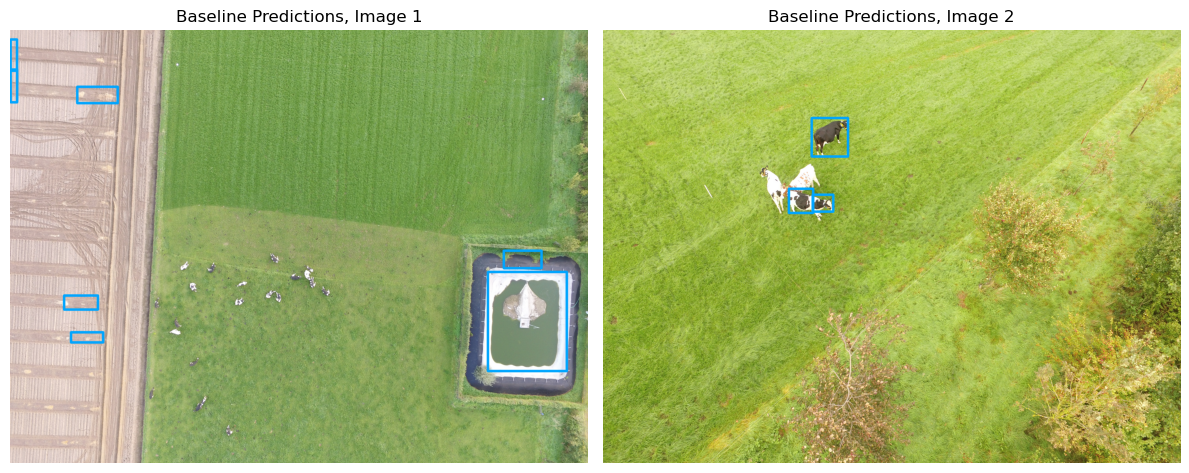

In [5]:
predictions_df_baseline = zenodo.fetch("test_baseline.csv")
predictions_df_baseline = pd.read_csv(predictions_df_baseline)

# Filter predicted boxes for the specific image
image_predictions_1 = predictions_df_baseline[predictions_df_baseline['image_path'] == image_name_1]
image_predictions_2 = predictions_df_baseline[predictions_df_baseline['image_path'] == image_name_2]

# Prepare bounding boxes DataFrame for plot_predictions
# Use xmin, ymin, xmax, ymax and label columns from predictions
boxes_df_1_baseline = image_predictions_1[['xmin', 'xmax', 'ymin', 'ymax', 'score']]
boxes_df_2_baseline = image_predictions_2[['xmin', 'xmax', 'ymin', 'ymax', 'score']]

# Plot bounding boxes on the image using deepforest.visualize
annotated_image_base_1 = plot_predictions(image_np_1, boxes_df_1_baseline, color=(0, 165, 255), thickness=15)
annotated_image_base_2 = plot_predictions(image_np_2, boxes_df_2_baseline, color=(0, 165, 255), thickness=15)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # Create 1 row, 2 column layout

axs[0].imshow(annotated_image_base_1)
axs[0].set_title("Baseline Predictions, Image 1")
axs[0].axis('off')  

axs[1].imshow(annotated_image_base_2)
axs[1].set_title("Baseline Predictions, Image 2")
axs[1].axis('off') 

# Show the side-by-side plots
plt.tight_layout()
plt.show()

False negatives can be observed, where the baseline model failed to detect some cows present in the ground truth annotations. This highlights areas where the model's initial performance can be improved through fine-tuning using local data to reduce these missed detections.

## Fine-tuned model

### Train model

In the DeepForest documentation, it is stated that "we have found that even an hour’s worth of carefully chosen hand-annotation can yield enormous improvements in accuracy and precision. 5-10 epochs of fine-tuning with the prebuilt model are often adequate." As such, the model is trained for 5 epochs.

Early stopping and callbacks are utilised, to ensure that the best model weights are saved.

<div style="background-color: #ffe4b5; padding: 10px; border-left: 5px solid #ffa500;">
<b>Note:</b> 
Since the Binder environment does not provide enough computational resources for training the model, the following code demonstrates how to set up and train the model in a more powerful local or cloud-based environment using PyTorch Lightning.
</div>

```python
import pytorch_lightning as pl

output_dir = os.path.join(notebook_folder, 'data')

train_file = os.path.join(output_dir, "train.csv")
valid_file = os.path.join(output_dir, "valid.csv")
test_file = os.path.join(output_dir, "test.csv")

model.label_dict = {'cow': 0}  # Rename label

# Configure the model for GPU usage and set the CSV file paths
model.config['gpus'] = '-1'  # Use GPU (set to '0' for the first GPU or '-1' for all GPUs)
model.config["train"]["csv_file"] = train_file  # Path to training CSV
model.config["train"]["root_dir"] = os.path.dirname(train_file)  # Root directory for training images
model.config["score_thresh"] = 0.4  # Set score threshold
model.config["train"]['epochs'] = 5  # Number of epochs
model.config["validation"]["csv_file"] = valid_file  # Path to validation CSV
model.config["validation"]["root_dir"] = os.path.dirname(valid_file)  # Root directory for validation images

early_stopping = EarlyStopping(monitor='box_recall', patience=2, mode='max')

callback = ModelCheckpoint(
    dirpath='checkpoints/',  # Directory to save checkpoints
    monitor='box_recall',  # Metric to monitor
    mode="max",  # Save when the metric is maximized
    save_top_k=3,  # Save the top 3 checkpoints
    filename="box_recall-{epoch:02d}-{box_recall:.2f}"  # File name format for checkpoints
)

logger = TensorBoardLogger(save_dir='logdir/')

model.create_trainer(logger=TensorBoardLogger(save_dir='logdir/'),
                                    callbacks=[callback, early_stopping])

model.trainer.fit(model)
```

### Save and upload checkpoint

After training the model, the following code saves the fine-tuned model checkpoint to a specified directory, ensuring that the model's progress can be easily reloaded or shared for further use. The checkpoint is saved in .ckpt format using PyTorch Lightning's `save_checkpoint()` method, and then uploaded to Hugging Face.

```python
checkpoint_dir = './drive/MyDrive/notebook/checkpoints_ckpt'
os.makedirs(checkpoint_dir, exist_ok=True)

# Save the model checkpoint as .ckpt
checkpoint_path = "{}/finetuned_checkpoint.ckpt".format(checkpoint_dir)
model.trainer.save_checkpoint(checkpoint_path)
```

### Load finetuned model

<div style="background-color: #ffe4b5; padding: 10px; border-left: 5px solid #ffa500;">
<b>Note:</b> 
Due to the memory constraints of the Binder environment, this step is omitted from the notebook. To execute locally, run the following code:
</div>

```python
# Download the finetuned model checkpoint from Hugging Face
ckpt_path = hf_hub_download(
    repo_id="camappel/deepforest-livestock",
    filename="finetuned_checkpoint.ckpt"
)

model = main.deepforest.load_from_checkpoint(ckpt_path)
```

The finetuned model also can be downloaded manually from [Hugging Face](https://huggingface.co/camappel/deepforest-livestock).

### Evaluate finetuned performance

The evaluate method assesses the fine-tuned model’s performance on the test dataset for comparison against the baseline, with predictions available as `test_finetuned.csv` on [Zenodo](https://zenodo.org/records/14219057).

<div style="background-color: #ffe4b5; padding: 10px; border-left: 5px solid #ffa500;">
<b>Note:</b> 
Due to the memory constraints of the Binder environment, this step is omitted from the notebook. To execute locally, run the following code:
</div>

```python
model.label_dict = {'cow': 0}  # Assign a unique integer ID to the 'cow' label
model.config['gpus'] = '-1'  # Use GPU (set to '0' for the first GPU or '-1' for all GPUs)
model.config['workers'] = 0

# Set the directory to save the results of the pretrained model
finetuned_save_dir = os.path.join(notebook_folder, 'finetuned_pred_result')
os.makedirs(finetuned_save_dir, exist_ok=True)

# Evaluate the pretrained model on the test set (using test_file)
finetuned_results = model.evaluate(test_path, os.path.dirname(test_path), iou_threshold=0.4, savedir=finetuned_save_dir)

test_finetuned_csv = os.path.join(finetuned_save_dir, 'test_finetuned.csv')
pd.DataFrame(finetuned_results['results']).to_csv(test_finetuned_csv, index=False)
```

### Visualise

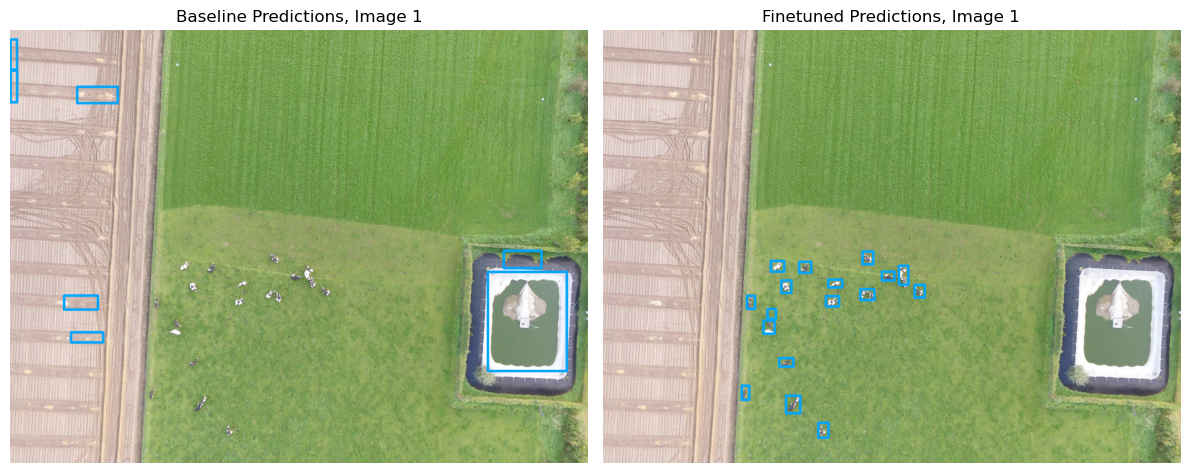

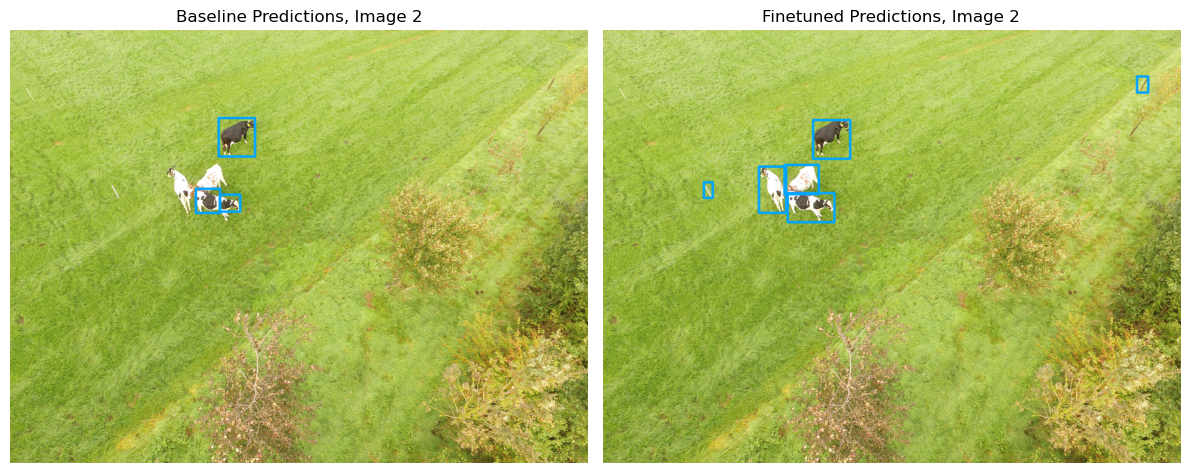

In [6]:
predictions_df_finetuned = zenodo.fetch("test_finetuned.csv")
predictions_df_finetuned = pd.read_csv(predictions_df_finetuned)

image_predictions_1 = predictions_df_finetuned[predictions_df_finetuned['image_path'] == image_name_1]
image_predictions_2 = predictions_df_finetuned[predictions_df_finetuned['image_path'] == image_name_2]

# Use xmin, ymin, xmax, ymax and label columns from predictions
boxes_df_1 = image_predictions_1[['xmin', 'xmax', 'ymin', 'ymax', 'label']]
boxes_df_2 = image_predictions_2[['xmin', 'xmax', 'ymin', 'ymax', 'label']]

annotated_image_fine_1 = plot_predictions(image_np_1, boxes_df_1, color=(0, 165, 255), thickness=15)
annotated_image_fine_2 = plot_predictions(image_np_2, boxes_df_2, color=(0, 165, 255), thickness=15)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # Create 1 row, 2 column layout

axs[0].imshow(annotated_image_base_1)
axs[0].set_title("Baseline Predictions, Image 1")
axs[0].axis('off')  

axs[1].imshow(annotated_image_fine_1)
axs[1].set_title("Finetuned Predictions, Image 1")
axs[1].axis('off') 

# Show the side-by-side plots
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # Create 1 row, 2 column layout

axs[0].imshow(annotated_image_base_2)
axs[0].set_title("Baseline Predictions, Image 2")
axs[0].axis('off')  

axs[1].imshow(annotated_image_fine_2)
axs[1].set_title("Finetuned Predictions, Image 2")
axs[1].axis('off') 

# Show the side-by-side plots
plt.tight_layout()
plt.show()

In [7]:
predictions_df_baseline[predictions_df_baseline['image_path'] == image_name_2].drop(columns=['label'])

,image_path,xmin,ymin,xmax,ymax,score
177,20181002 (228).JPG,1444.2823,615.0275,1695.3130,881.9138,0.970427
178,20181002 (228).JPG,1286.4039,1104.1315,1454.1184,1271.8566,0.513814
179,20181002 (228).JPG,1451.1173,1145.0674,1593.5060,1262.3131,0.241456


In [8]:
predictions_df_finetuned[predictions_df_finetuned['image_path'] == image_name_2].drop(columns=['label'])

,image_path,xmin,ymin,xmax,ymax,score
241,20181002 (228).JPG,1454.09300,629.81726,1710.7650,897.26060,0.964095
242,20181002 (228).JPG,1278.33410,1134.26930,1601.2174,1335.24880,0.921762
243,20181002 (228).JPG,1079.45100,951.77515,1267.1416,1270.30080,0.779635
244,20181002 (228).JPG,1256.86170,939.63940,1493.0862,1141.79200,0.728493
245,20181002 (228).JPG,698.70483,1059.99600,759.7376,1167.02640,0.308100
246,20181002 (228).JPG,3695.01640,328.42743,3773.0945,439.15424,0.167706


While the fine-tuned model also predicted false positives in Image 2, the evaluation csv shows that their IoU scores are below the threshold of 0.4. The fine-tuned model shows a significant improvement, successfully detecting all cows in the test imagery without any false negatives, demonstrating the effectiveness of fine-tuning on local data.

## Summary

This notebook demonstrates the process of fine-tuning the DeepForest livestock detection model, achieving notable performance improvements after training for 5 epochs. The model was fine-tuned on a labeled aerial dataset of cows from Dataverse (2347 training and 690 validation samples). Performance on the test set (356 samples), which consisted of images excluded from training and validation, showed substantial gains across key metrics:

- __Box Recall:__ Improved from 0.3862 to 0.9391
- __Box Precision:__ Improved from 0.4925 to 0.8628
- __Mean IoU:__ Improved from 0.2070 to 0.6095

These results highlight the effectiveness of fine-tuning and open-sourcing, significantly boosting the model's ability to accurately detect livestock in aerial imagery.

## Citing this Notebook

Please see [CITATION.cff](https://github.com/eds-book/95199651-9e81-4cae-a3a7-66398a9a5f62/blob/main/CITATION.cff) for the full citation information. The citation file can be exported to APA or BibTex formats (learn more [here](https://docs.github.com/en/repositories/managing-your-repositorys-settings-and-features/customizing-your-repository/about-citation-files)).

## Additional information

**Review**: This notebook has been reviewed by one or more members of the Environmental Data Science book community. The open review is available [here](https://github.com/alan-turing-institute/environmental-ds-book/issues/260).

**Dataset**: "Annotated cows in aerial images for use in deep learning models" Version 1 {cite:p}`livestockdataset`

**Codebase**: DeepForest [v1.4.0](https://github.com/weecology/DeepForest)

**Codebase developers**:
* Ben Weinstein (maintainer & developer), University of Florida, [@bw4sz](https://github.com/bw4sz)
* Henry Senyondo (support maintainer), University of Florida, [@henrykironde](https://github.com/henrykironde)
* Ethan White (PI and author), University of Florida, [@ethanwhite](https://github.com/ethanwhite)

**License**: The code in this notebook is licensed under the MIT License. The Environmental Data Science book is licensed under the Creative Commons by Attribution 4.0 license. See further details [here](https://github.com/alan-turing-institute/environmental-ds-book/blob/main/LICENSE).

**Contact**: If you have any suggestion or report an issue with this notebook, feel free to [create an issue](https://github.com/alan-turing-institute/environmental-ds-book/issues/new/choose) or send a direct message to [environmental.ds.book@gmail.com](mailto:environmental.ds.book@gmail.com).

In [9]:
from datetime import date

print('Notebook repository version: v2.0.0')
print(f'Last tested: {date.today()}')

Notebook repository version: v2.0.0
Last tested: 2025-05-16
